In [1]:
import stim
import numpy as np
import itertools
from copy import copy
from copy import deepcopy

### Fidelity of Bell pair vs. depolarizing noise on single qubit:

$$\mathcal{E}(\rho) = (1-p)\;\rho + \frac{p}{3} \;(X_1 \rho X_1 + Y_1 \rho Y_1 + Z_1 \rho Z_1) $$

Therefore $F(\mathcal{E}(\rho)) = (1-p)$

### Effect of parity check purification with depolarized bell pair:

Let $\rho_{in} = \mathcal{E}(\rho) \otimes \mathcal{E}(\sigma)$

[0.70710677+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.70710677+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]


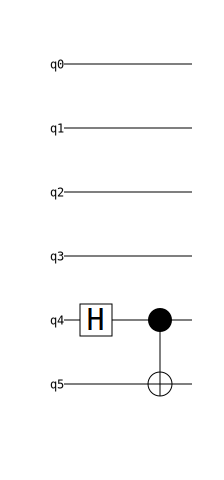

In [20]:
def ideal_pair_sv():
    circuit = stim.Circuit()
    circuit.append("H", 4)
    circuit.append("CNOT", [4,5])
    simulator = stim.TableauSimulator()
    simulator.do(circuit)
    return circuit, simulator.state_vector()

ideal_circuit, ideal_sv = ideal_pair_sv()
print(ideal_sv)
ideal_circuit.diagram(type="timeline-svg")

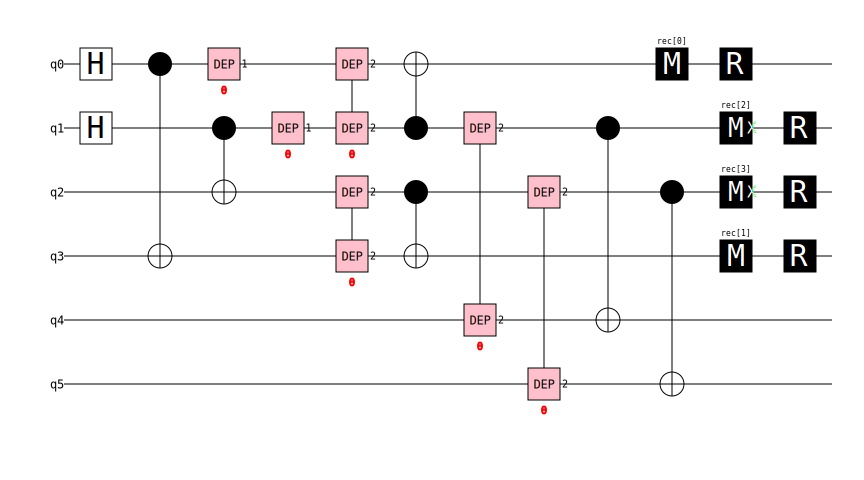

In [23]:
def simple_pair_fidelity(p1 = 0, p2 = 0.00):
    circuit = stim.Circuit()
    # Bell state preperation
    circuit.append("H", [0,1])
    circuit.append("CNOT", [0,3,1,2])
    circuit.append("DEPOLARIZE1", [0,1], p1)
    # Error prone cloning and teleportation
    circuit.append("DEPOLARIZE2", [1,0,2,3], p2)
    circuit.append("CNOT", [1,0,2,3])
    circuit.append("DEPOLARIZE2", [1,4,2,5], p2)
    circuit.append("CNOT", [1,4,2,5])
    circuit.append("MZ", [0,3])
    circuit.append("MX", [1,2])
    circuit.append("R", [0,1,2,3])
    return circuit

circuit = simple_pair_fidelity()
circuit.diagram(type="timeline-svg")

In [58]:
simulator = stim.TableauSimulator()
simulator.do(circuit)
results = simulator.current_measurement_record()
tf = {True:0, False:1}
print(f"Purification measurements {tf[results[0]], tf[results[1]]}")
print(f"Teleportation measurements {tf[results[2]], tf[results[3]]}")
if results[-2]: simulator.z(4);
if results[-1]: simulator.z(5);
print(simulator.state_vector())

# Probably this is just undetectable Z and X error. Can we account for this?
# Interestingly though, there are measurement scenarios where purification *FAILS* but still correctly teleports if 
# measurement parities coincide. Is this accidental?

Purification measurements (0, 0)
Teleportation measurements (1, 0)
[0.70710677+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.70710677+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.

In [21]:
# Interestingly, this is even without post-selecting on specific measurement outcomes
def estimate_fidelity(circuit, num_trials):
    aveF = 0
    for i in range(num_trials):
        simulator = stim.TableauSimulator()
        simulator.do(circuit)
        results = simulator.current_measurement_record()
        if results[-2]: simulator.z(4);
        if results[-1]: simulator.z(5);
        F = np.inner(simulator.state_vector(), ideal_sv)
        aveF += F
    aveF = aveF / num_trials
    return aveF

estimate_fidelity(circuit, 10000)

(0.9685999421362543+0j)

In [574]:
# Interestingly, this is even without post-selecting on specific measurement outcomes
def estimate_fidelity_with_postselection(circuit, num_trials):
    aveF = 0
    num_misses = 0
    for i in range(num_trials):
        simulator = stim.TableauSimulator()
        simulator.do(circuit)
        results = simulator.current_measurement_record()
        if results[-3] != results[-4]: num_misses += 1;
        else:
            if results[-2]: simulator.z(4);
            if results[-1]: simulator.z(5);
            F = np.inner(simulator.state_vector(), ideal_sv)
            aveF += F
    aveF = aveF / (num_trials - num_misses)
    # debug 
    return aveF

print(estimate_fidelity(circuit, 10000))
estimate_fidelity_with_postselection(circuit, 10000)

(0.9701999420370794+0j)


(0.9745067703338359+0j)

In [526]:
import matplotlib.pyplot as plt

/tmp/ipykernel_4659/1791972050.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  f = float(estimate_fidelity(circuit, num_trials))
/tmp/ipykernel_4659/1791972050.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  f_post = float(estimate_fidelity_with_postselection(circuit, num_trials))


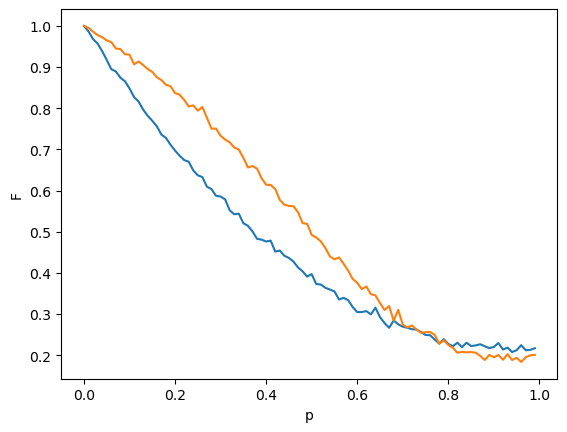

In [579]:
def plot_fidelity_with_prob(num_trials, show_progress=False):
    p_err = np.arange(0., 1., 0.01)
    Fs = []
    Fs_with_post = []
    for p in p_err:
        if show_progress: print(f"Sampling error rate {p}");
        circuit = simple_pair_fidelity(p1 = p, p2 = 0)
        f = float(estimate_fidelity(circuit, num_trials))
        f_post = float(estimate_fidelity_with_postselection(circuit, num_trials))
        Fs.append(f)
        Fs_with_post.append(f_post)
    return Fs, Fs_with_post

Fs, Fs_with_post = plot_fidelity_with_prob(5000)
p_err = np.arange(0., 1., 0.01)
plt.plot(p_err, Fs)
plt.plot(p_err, Fs_with_post)
plt.xlabel("p")
plt.ylabel("F")
plt.show()

In [601]:
# More tests
def bell(p):
    circuit = stim.Circuit()
    circuit.append("H", 0)
    circuit.append("CNOT", [0,1])
    circuit.append("DEPOLARIZE1", 0, p)
    simulator = stim.TableauSimulator()
    simulator.do(circuit)
    return circuit

# c.diagram(type="timeline-svg")

F = 0
N = 100
for i in range(N):
    c = bell(0.99)
    simulator = stim.TableauSimulator()
    simulator.do(c)
    sv = simulator.state_vector()
    ideal_bell = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)])
    F += np.inner(sv, ideal_bell)
print(F / 100)

(0.009999999828857289+0j)
